# <center> The Gender Gap </center>

### <center> STA141B Final Project by Hannah Kosinovsky and Niveditha Achanta </center>

For our final project, we chose to analyze the gender achievement gap between males and females. Since this is such a nuanced and subjective topic of interest, we split our analysis and observations into four distinct parts. Our project overview is as follows:

**Introduction and Motivation:** Why is our research important? What social implications could it have?

**Part 1:** Summary of Pew Research Institute findings

**Part 2:** Urban Dictionary qualitative visualization

**Part 3:** Parental leave benefits analysis  

**Part 4:** American Time Use Survey

**Conclusion and Considerations:** What did we learn from our analysis? What are some caveats that need to be addressed during this process? What could we do in the future to bolster our findings or dig deeper into this topic?  

These parts will be explained in more detail in the body of the report. Each part will also delve deeper into the motivation and analytical process, to help readers better understand our datasets, methodology, and the subjective decisions we made to arrive at our conclusions. Additionally, our code is commented to help readers follow along with our process.

## Introduction and Motivation

For our project, we want to see if we can find quantifiable social phenomena that explain the gender achievement gap between men and women. There is [plenty of discussion](https://en.wikipedia.org/wiki/Gender_inequality_in_the_United_States) about gender inequality in the United States, and the Pew Research Center published a [study](http://www.pewsocialtrends.org/2015/01/14/women-and-leadership/) in early 2015 about women and leadership that essentially concluded that the "public says women are equally qualified [as men], but barriers persist. The Pew article's findings will be explained in more detail in Part 1 and referenced throughout our report, but essentially, we want to find out how else we can account for this achievement differential. If the public believes that men and women are equally qualified for leadership, why is there still a gender difference, especially at higher levels of power? 

We have a few hypotheses we want to test during the course of our project. If public opinion cannot explicitly explain the achievement gap (keeping in mind that this survey may still have response bias), we believe that there must be more implicit social or structural trends that play a role in motivating (or demotivating) women to achieve at different levels than their male counterparts. 

To expand on that, we have identified a few critical factors that we believe could play a role in assessing the gender achievement gap: social perception, structural differences, and domestic activities. The last two are more quantifiable than the first, and as our report progresses, we will shift from trying to deconstruct our social fabric to analyzing pay structures and time use. 

First, we will resummarize the findings of the Pew Research Institute to properly contextualize our analysis. Then, we will webscrape the Urban Dictionary definitions of "women" and "men" to glean some insight on perception of the two genders, and draw subjective conclusions and identify things that stand out to us, stating stipulations as we go along. We will examine the differences in paid maternity and paternity leave across companies and industries and contextualize our findings with information about gender distribution in publicly traded companies that we can research, and finally look at how married American women and men spend their time working and doing domestic activities and childcare. 

There are many subtle components that add up over the lifetime of a person that will determine their achievement and limitations on their potential, but we believe that our melange of less explicit social phenomenon, maternity/paternity leave information, and analysis of general daily activities provides a fairly comprehensive start to determine what factors the gender achievement gap can be attributed to. 

## Part 1: Summary of Pew Research Institute Findings 

Some key findings from the [Pew article](http://www.pewsocialtrends.org/2015/01/14/women-and-leadership/) are displayed below, and summarized below each image: 

<img src = http://assets.pewresearch.org/wp-content/uploads/sites/3/2015/01/ST_2015-01-14_women-leadership-0-01.png>

<img src = http://assets.pewresearch.org/wp-content/uploads/sites/3/2015/01/ST_2015-01-14_women-leadership-0-02.png>

In [204]:
# THE BASICS
import pandas as pd 
import numpy as np
import os
import glob
import sys

# WEBSCRAPING AND TEXT ANALYSIS
import requests
import requests_ftp
import requests_cache
import lxml
import re
import urllib
from wordcloud import WordCloud, STOPWORDS
import random
from bs4 import BeautifulSoup
from collections import Counter

# PLOTTING
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# STATS
from scipy import stats

# CACHE 
requests_cache.install_cache('demo_cache')

## Part 2: Urban Dictionary Qualitative Visualization
*_Results may be NSFW_

**Social Context**

After looking at the conclusions from the Pew Institute's article, we wanted to see if we could conduct a more qualitative analysis of the discrepancy of women and men in society. One of the things we discussed is perception: despite the fact that women and men are believed to have equal capabilities, how are they perceived? How can we examine perception through current social trends?

There have already been experiments (such as the famous [Heidi Roizen case study](http://www.leadershippsychologyinstitute.com/women-the-leadership-labyrinth-howard-vs-heidi/)) that declare there to be a significant difference in the way different genders are perceived in the workplace. To frame these ideas through a larger (and potentially more abstract) social lens, we decided to webscrape the Urban Dictionary definitions for "women" and "men", as well as the examples, to see if anything stood out. You can look at the Urban Dictionary format for "women" [here](http://www.urbandictionary.com/define.php?term=Women) for an idea of what the website's layout is. 

**Methodology** 

We made four word clouds to create a visual representation of our results. We made two for women and two for men (for "definition" and "example" for each). 

First, we made a function that returns Urban Dictionary definitions for the first page.

In [205]:
# DEFINE THE FUNCTION
def urbandic(term, section):
    """
    accept the search term and section (either meaning or example) as an argument and
    return the full set of meanings or examples for the first page 
    """
    initial_url = 'http://www.urbandictionary.com/'
    term = "define.php?term=" + term
    full_url = initial_url + term 
    
    # GET THE HTML
    page = requests.get(full_url)
    page_html = page.text
    soup = BeautifulSoup(page_html, 'lxml')
    
    # FIND WHAT WE'RE INTERESTED IN AFTER INSPECTING ELEMENT
    sec = soup.find_all("div", {'class': section}) #[4] #this has various elements, so run a list comprehension
    text = "".join([x.getText() for x in sec]).split("\n"); #gets all the text 
    
    # CLEAN IT UP 
    text[:] = (value for value in text if value != '') #get rid of blank unicode objects
    definitions = [re.sub("\r", "", i) for i in text]
    return definitions 

Then, we created another function to work for all of the pages in Urban Dictionary. They have a "last" page, which makes it easy for us to find the range of our pages when we finally call the function. You will notice below that there is also a parameter called `oursection`. This lets us input "meaning" or "example", since those are the two things we are interested in for each gender and are located in different parts of the HTML. 

In [206]:
# DEFINE THE FUNCTION
def urban(searchterm, oursection, page=1): #default page = 1 
    """
    accept the search term and section (either meaning or example) as an argument and
    return the full set of meanings or examples for any number of pages
    """
    if page == 1:
        #ourlist = ["meaning", "example"]
        return(urbandic(searchterm, oursection))
    
    # FOR MULTIPLE PAGES 
    if page > 1:
        pages_wanted = [searchterm+"&page="+str(x) for x in range(1,page+1)]
        all_articles = [urbandic(page, oursection) for page in pages_wanted]
        return([item for sublist in all_articles for item in sublist]) #unlist

Now that we have functions that scrape the relevant content from Urban Dictionary, we can create one list for each word cloud's input. 

In [207]:
# CREATE LISTS
women = urban("women", "meaning", 35) #Create a list for all meanings for "women", since UD's "last" button gives us #pages
womEx = urban("women", "example", 35) #List for women examples
men = urban("women", "example", 9)
menEx = urban("men", "example", 9) 

Before we create our word clouds, we have to set stopwords, which are words not included in the cloud. These are extremely subjective and we ran our word clouds a few times before deciding what to do. You will notice that some words like "thing" and "make" are included-- we erred on the side of inclusion, i.e., if there was a filler word that seemed like it could be definitionally significant, we kept it in our display. 

In [208]:
# STOPWORDS
stopwords = STOPWORDS
more_stopwords = set(["women", "men", "human", "female", "said", "woman", "guys", "being", "man", "male", "will", "one", "also", "often",
                     "time", "way", "always", "extremely", "people", "guy", "girl", "mens"]) #stopwords are subjective
stopwords = set(stopwords).union(more_stopwords)

In [209]:
# WORDCLOUD FUNCTION 
def wordcloud(term, title): 
    want = [item for item in term if item not in stopwords]
    want = " ".join(want)
    
    # GENERATE WORDCLOUD IMAGE
    wc = WordCloud(background_color = "white", max_words=5000, stopwords=stopwords, width=800, height=400)

    # GENERATE WORDCLOUD
    wc.generate(want)

    # COLOR IT GRAYSCALE
    def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(50, 0%%, %d%%)" % random.randint(10, 50)

    # PLOTTING
    plt.figure(figsize=(20,10))
    plt.imshow(wc.recolor(color_func = grey_color_func, random_state=3))
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(title, size = 100)
    plt.show()

**Results**

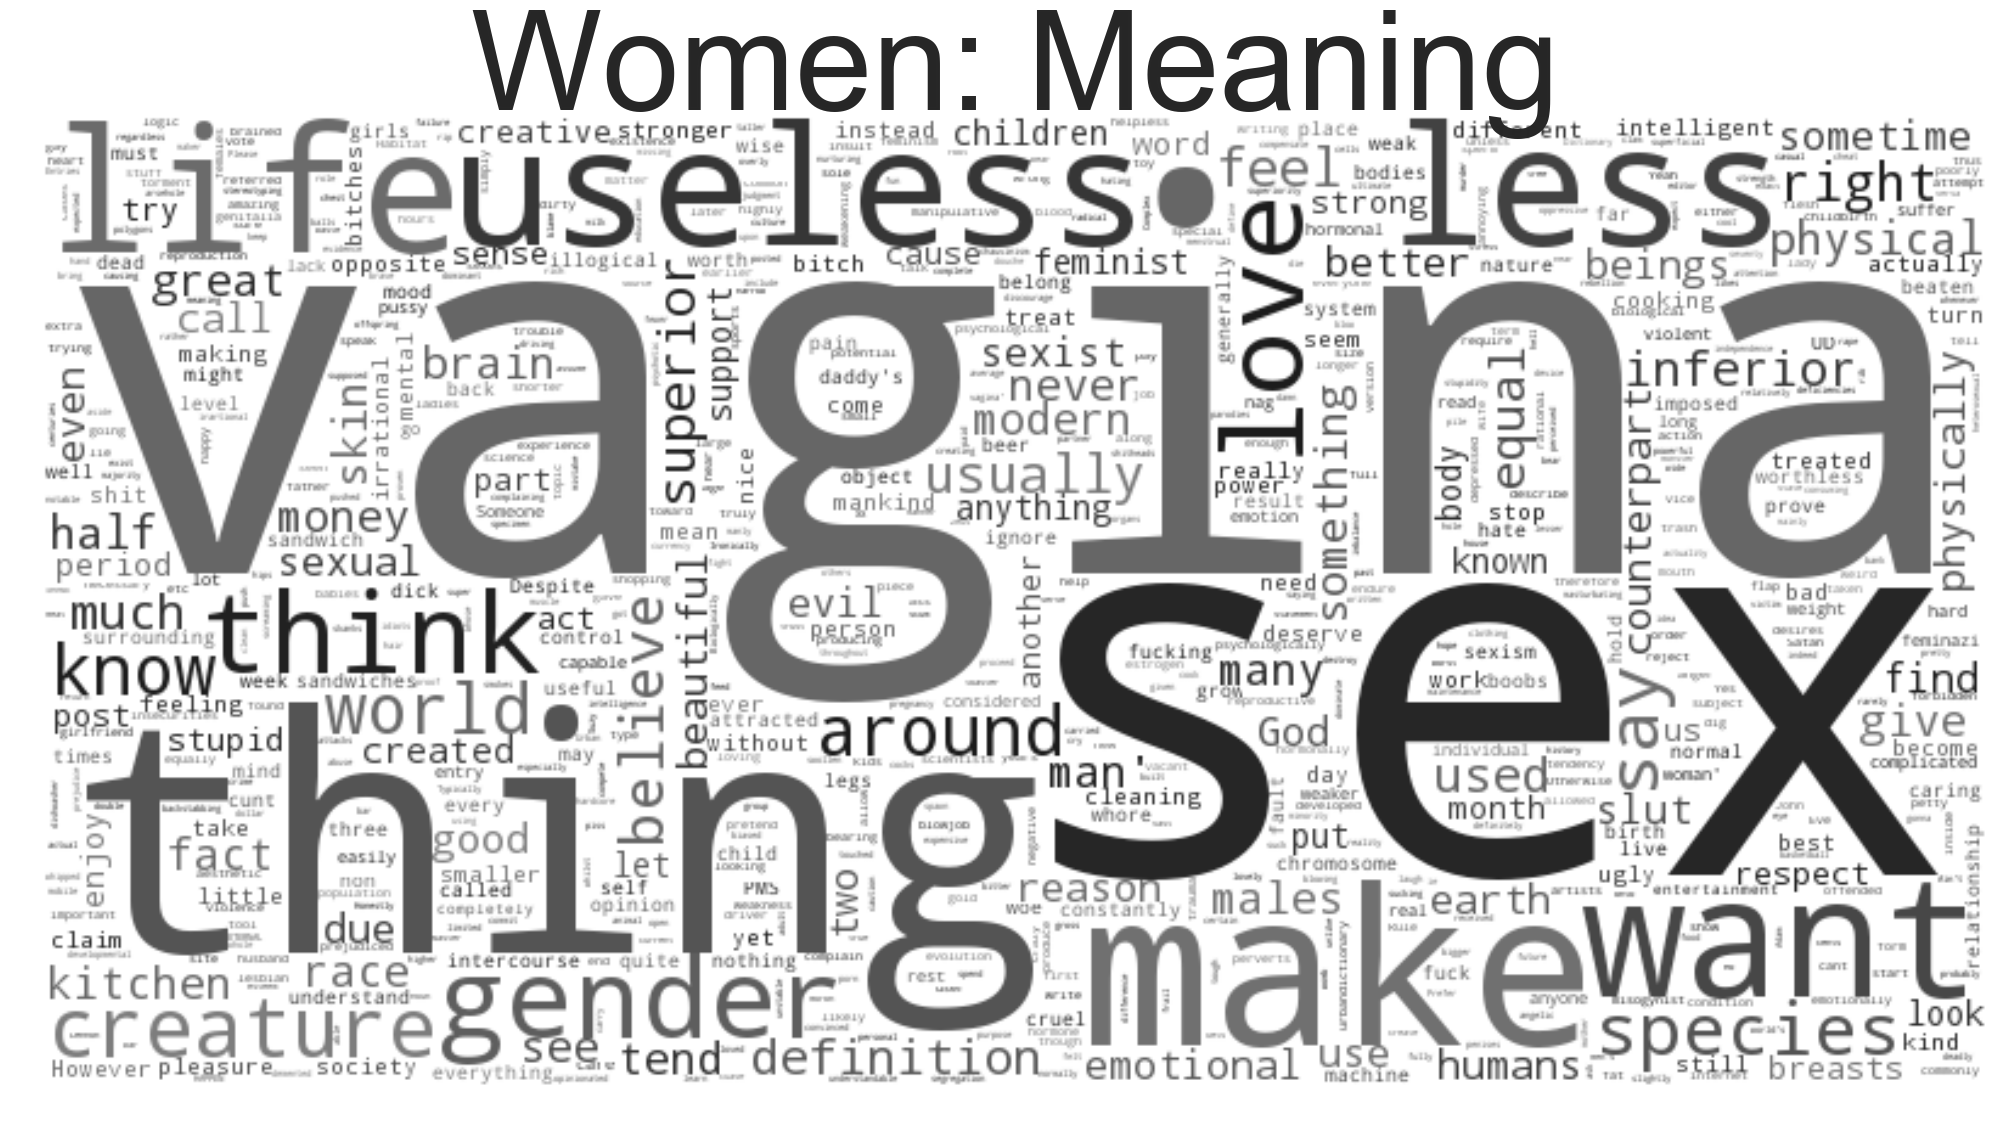

In [210]:
wordcloud(women, "Women: Meaning")

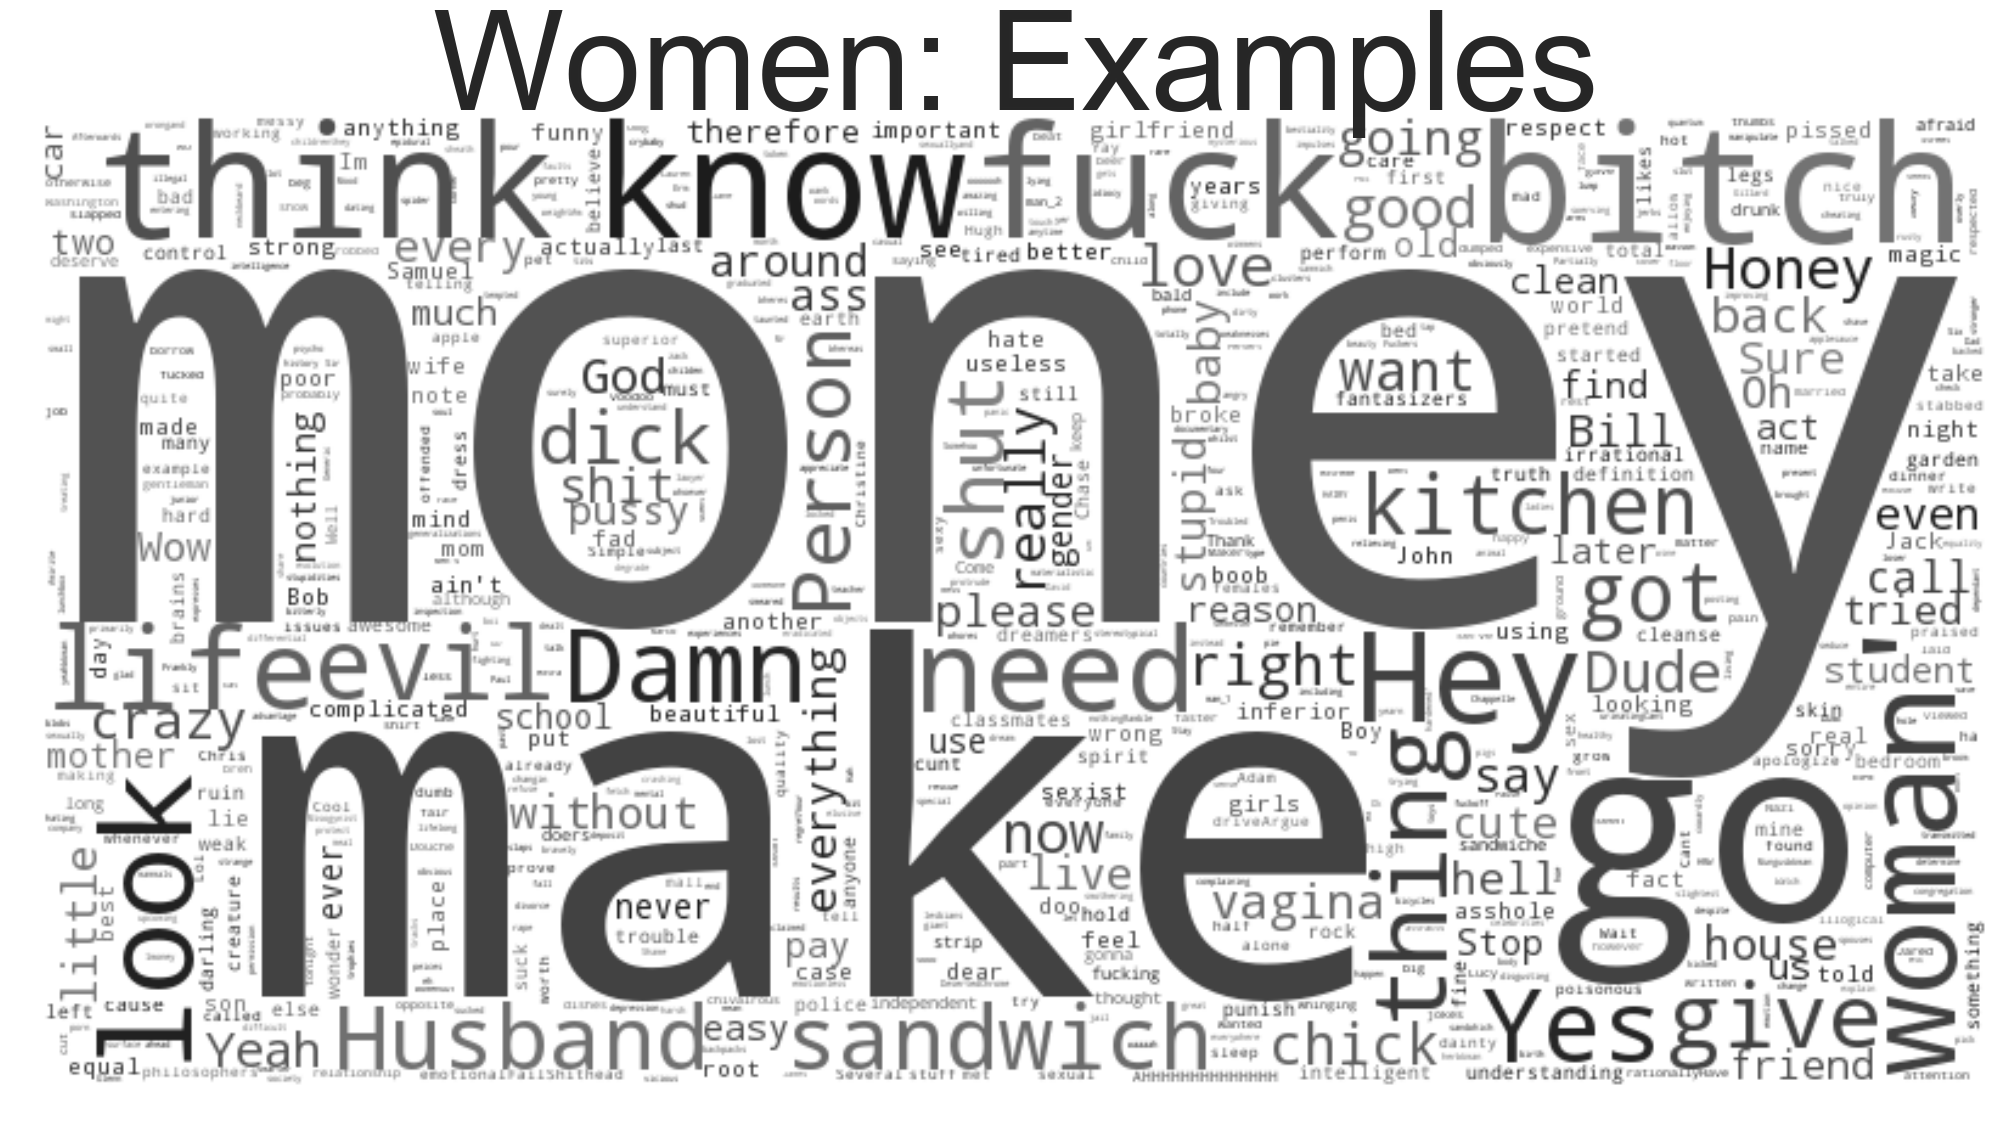

In [211]:
wordcloud(womEx, "Women: Examples")

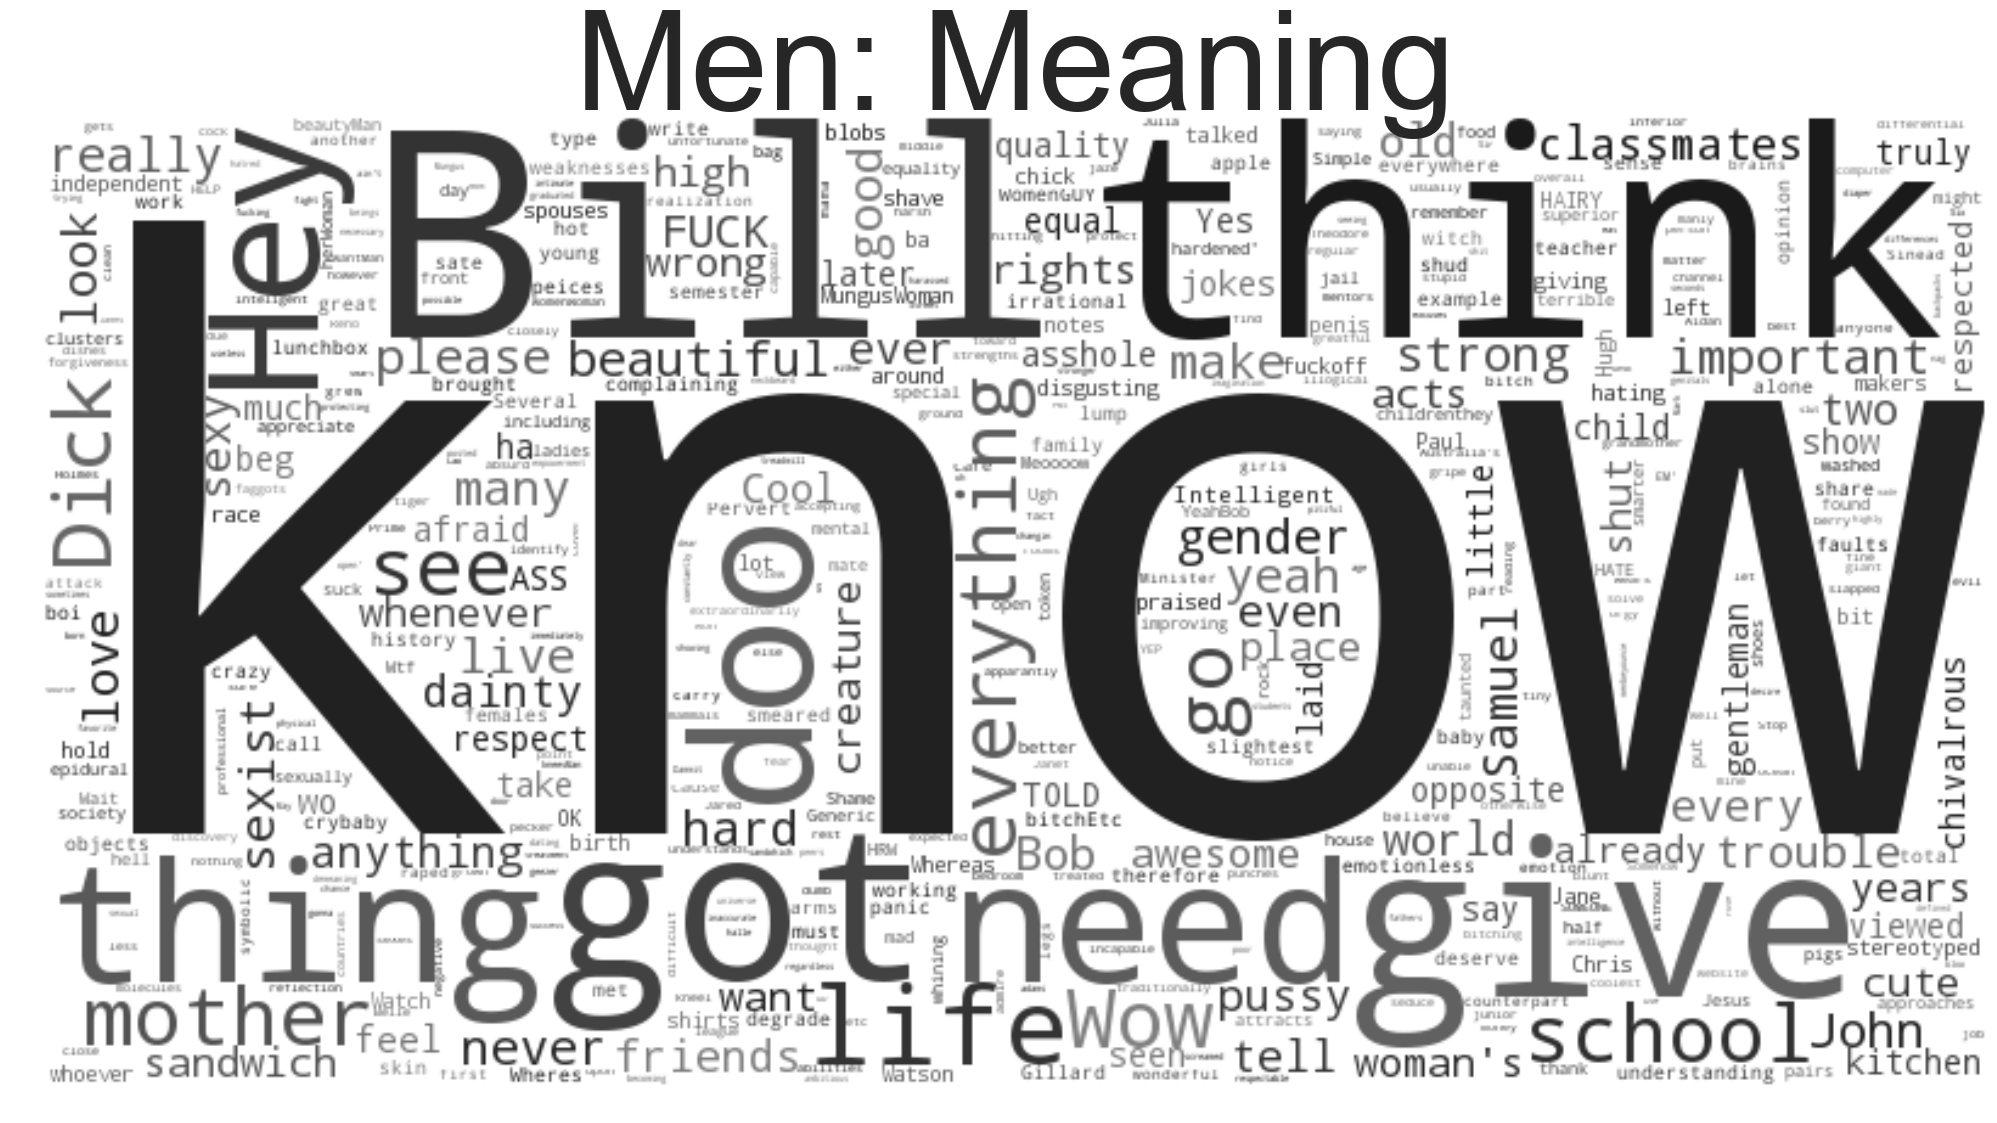

In [212]:
wordcloud(men, "Men: Meaning")

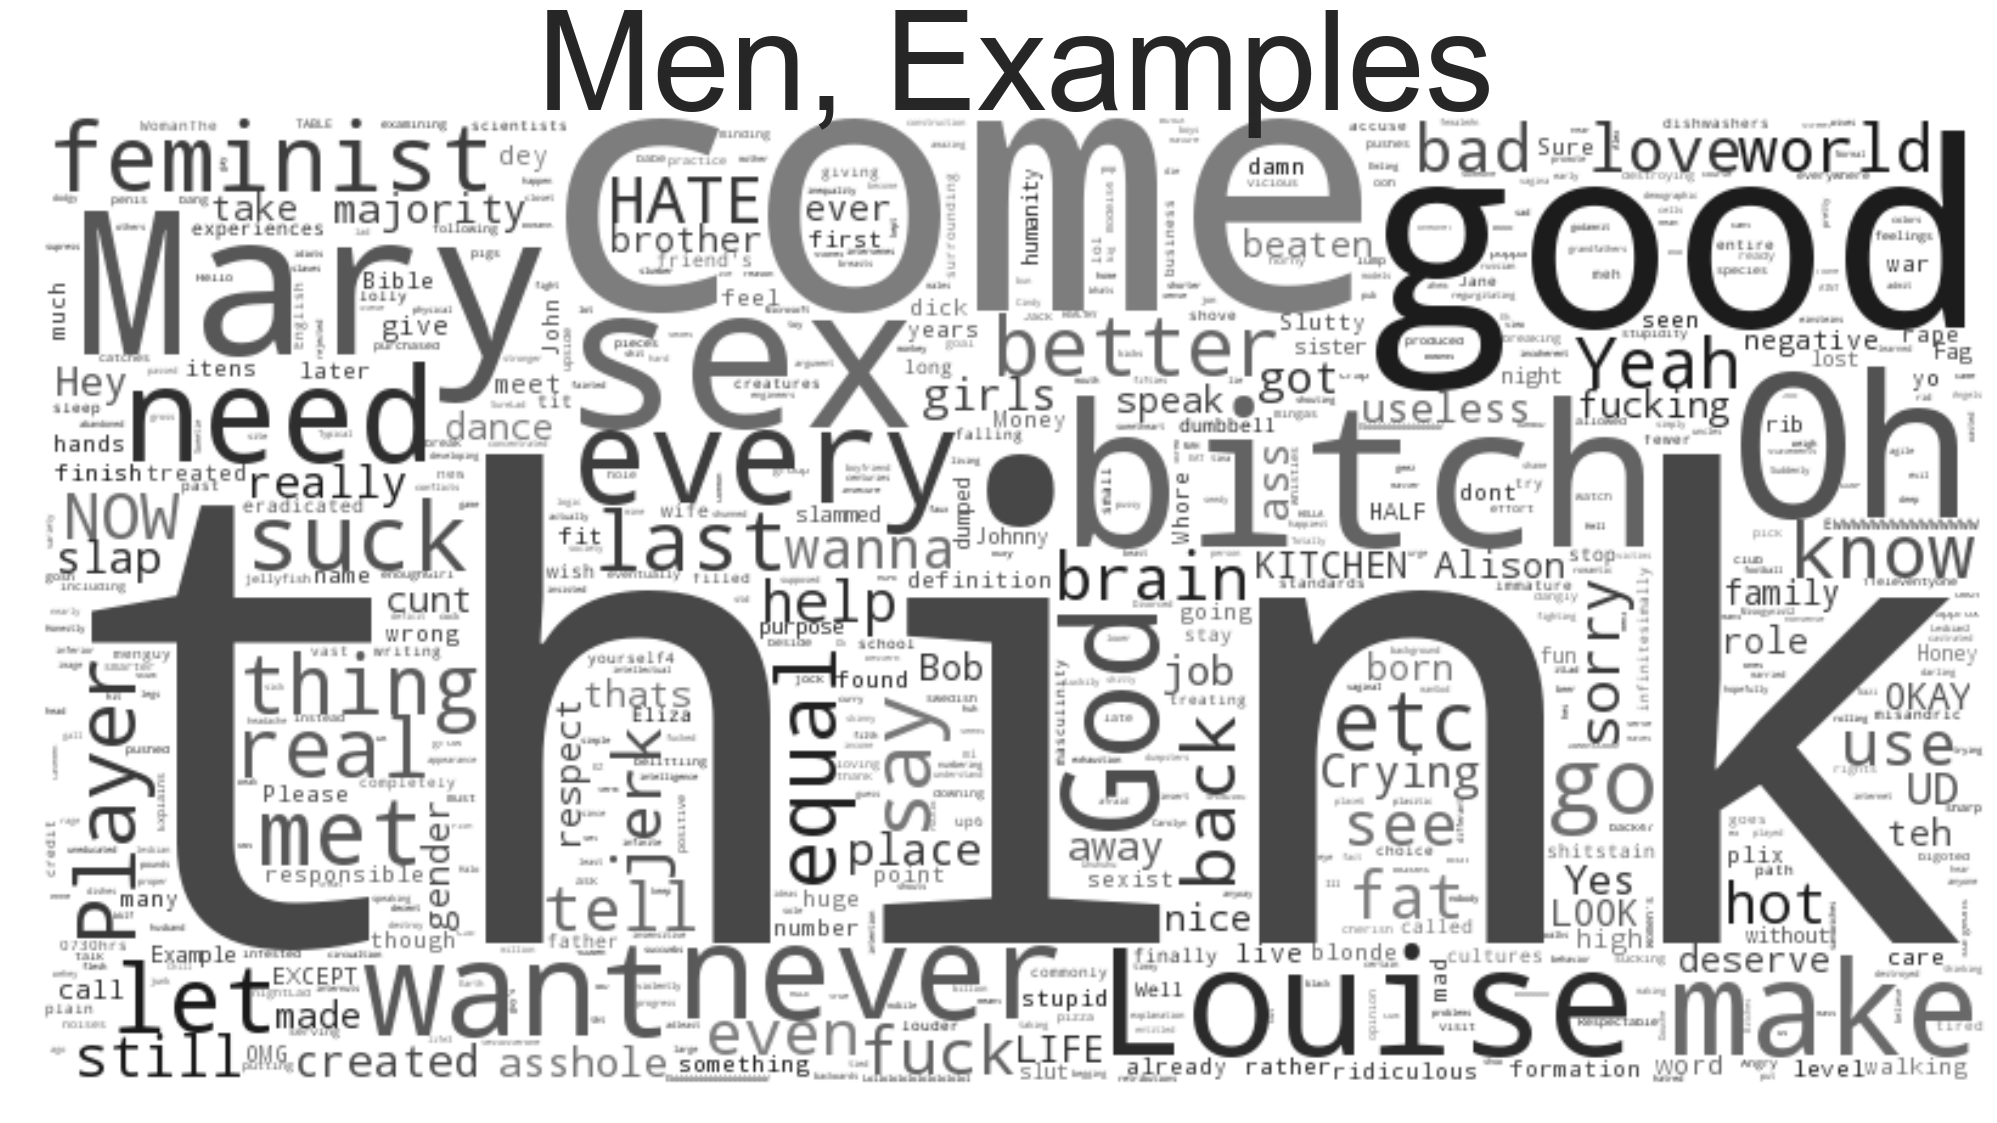

In [213]:
wordcloud(menEx, "Men, Examples")

**Observations and Comments**

Obviously, the very nature of Urban Dictionary (public, crowdsourced, largely unverified, often spam definitions) makes it so that we cannot draw conclusions from these displays without reliability or bias. That being said, we believe that looking at some of the nuances and overarching characteristics of the word clouds sheds important insight on social implications.

Before we constructed our word cloud itself, we noticed that there are _35 pages_ of definitions for "women" and only _9 pages_ for men. We cannot say what this actually means, but it is a remarkable difference that should be mentioned. After creating and looking at our word clouds, we noticed a few things. First of all, the "meaning" section for women has a lot more negative connotations than that of men. Some words that stand out in the former are "less" and "wantless", whereas some words for men are "know", "got", and "strong". As we mentioned, we do have to take into account that repeated words _may not necessarily_ be important, and might be used as stopwords, but in the overall clouds, there are far more negatively connoted words that stand out for women. 

Another interesting observation is that in the "examples" section for men, there are some proper nouns ("Mary", Louise") that stand out, as compared to the same section for women, which has more noticeable "domestic" nouns such as "husband", "honey", and "kitchen". Again, although we can't necessarily quantify these observations, we believe that the stark differences across the content of both genders is in some way reflective of our social fabric. The lack of reliability and presence of bias in Urban Dictionary is one of the reasons we chose this website; social trends cannot all be quantified in surveys and studies, and we thought that Urban Dictionary would let us do a preliminary analysis through a relevant and current website. Urban Dictionary by no means is a comprehensive representation of our social fabric, but it gives us (shocking, in our opinion) insight into how gender is perceived in our society, and could indirectly affect achievement.

## Part 3: Parental Leave Benefits Analysis

**Social Context** 

The following excerpt from [the Pew article](http://www.pewsocialtrends.org/2015/01/14/women-and-leadership/) states the following: 

<a href="http://tinypic.com?ref=111igbc" target="_blank"><img src="http://i66.tinypic.com/111igbc.png" border="0" alt="Image and video hosting by TinyPic"></a>

We believe that there are many stages in a person's life that determine their achievement potential, and for women, one significant setback, rooted in the misfortunate allocation of science and anatomy, is the prospect of childbirth. This is a necessary and (for many) much-desired process, so we wanted to look into corporate structures to examine how different companies and organizations actually support maternity and paternity leave. We found a website called [fairygodboss](fairygodboss.com/maternity-leave-resource-center) that crowdsources the number of weeks companies provide for maternity and paternity leave, both paid and unpaid. The intention behind examining these benefits is to see if significant differences exist between paid maternity and paid paternity leave (we will choose to only focus on paid leave for this project) to see if the achievement gap can be attributed (at least in part) to _structural_ differences in the workplace. 

Fairygodboss disperses information on a wide range of industries, so we focus on four that we believe will be the most pertinent: Business, Government, Technology, and Nonprofit. We chose business and government since the Pew article has sections that survey respondents about criteria that makes for "top executive positions" in business and government. We wanted to also examine the technology and nonprofit sectors, since technology is one of the most quickly growing sector today, and the achievement gap in both these areas were mentioned in Sheryl Sandberg's [famous TED talk](http://www.ted.com/talks/sheryl_sandberg_why_we_have_too_few_women_leaders). 



**Methodology**

The Fairygodboss website has 79 pages worth of information for various companies, so first we scraped all the pages into the dataframe below. 

In [214]:
# WEBSCRAPING FAIRYGODBOSS
url_req = requests.get("https://fairygodboss.com/maternity-leave-resource-center")
html = url_req.text
soup = BeautifulSoup(html, 'lxml')

In [215]:
# GET SECTION WITH COMPANY INFO
company_info_all = []
for i in range(80): # we know that "end" page on the site is 79
    base_url = 'https://fairygodboss.com/maternity-leave-resource-center'
    page = base_url + '?page=' + str(i)
    url_req = requests.get(page)
    html = url_req.text
    soup = BeautifulSoup(html, 'lxml')
    
    # GET INFO
    company_info = soup.select('a[href*="/company-overview/"]') #after inspecting element, this is where our info is 
    company_info_all.append(company_info)
#company_info_all[1]

In [216]:
# CREATE EMPTY LISTS FOR DATAFRAME: we need company name, industry, and 2 types of leave for each type of parent 
name = []
industry = []
mat_leave_pd = []
mat_leave_unp = []
pat_leave_pd = []
pat_leave_unp = []
for i in range(len(company_info_all)):
    company_info = company_info_all[i] #extract element from list
    for i in range(len(company_info)):
        s = company_info[i] #extract element from sublist to get relevant information
        #print s
        
        for i in range(len(s)):
            
            #s.find_all('li') has 6 different elements that we want, so we can use the indices 0:5 to find them
            name.append(s.find_all('li')[0].text.strip("\n"))
            industry.append(s.find_all('li')[1].text.split(' \n')[1].strip())
            mat_leave_pd.append(s.find_all('li')[2].text.split(' \n')[1].strip())
            mat_leave_unp.append(s.find_all('li')[3].text.split(' \n')[1].strip())
            pat_leave_pd.append(s.find_all('li')[4].text.split(' \n')[1].strip())
            pat_leave_unp.append(s.find_all('li')[5].text.split(' \n')[1].strip())

# CREATE DATAFRAME
df = pd.DataFrame({"name":name, "industry":industry, "maternity leave paid":mat_leave_pd, "maternity leave unpaid":mat_leave_unp, "paternity leave paid":pat_leave_pd, "paternity leave unpaid":pat_leave_unp})
df.dropna()

# DROP DUPLICATES, KEEPING ONLY ONE OF EACH COMPANY
df.drop_duplicates(subset = ['name'], keep = 'first', inplace = True)

In [217]:
# INDUSTRIES
#df['industry'].value_counts()

# SPLIT FOR SECTOR 
df['sector'] = [s.replace(":", "").split(" ")[0] for s in df['industry']]

Then, we created a new dataframe called `sectordf` with our 4 sesctors. We'll drop all the N/A items-- if there's no information to compare maternity and paternity leave, we choose to leave it out of our analysis. 

In [222]:
# GET ALL ROWS FOR WHICH THE INDUSTRY STARTS WITH ONE OF OUR 4 CRITERIA 
sectordf = df.loc[df.industry.str.startswith(("Technology", "Nonprofit", "Business", "Government")), :]
sectordf = sectordf[['industry','sector', 'name','maternity leave paid', 'paternity leave paid']]

# REMOVE ALL N/A ROWS
sectordf = sectordf[~sectordf['maternity leave paid' and 'paternity leave paid'].str.contains("N")]

# CONVERT MAT AND PAT LEAVE TO NUMERIC
sectordf['maternity leave paid'] = pd.to_numeric(sectordf['maternity leave paid'], errors = 'coerce')

#FIX THIS REDUNDANCY
sectordf['paternity leave paid'] = pd.to_numeric(sectordf['paternity leave paid'], errors = 'coerce')
sectordf.head()

industry      sector            name  \
0   Technology: Consumer Internet  Technology         Netflix   
26            Government: Federal  Government  Army (British)   
52  Technology: Consumer Internet  Technology            Etsy   
65  Technology: Consumer Internet  Technology         Spotify   
78           Technology: Software  Technology   Adobe Systems   

    maternity leave paid  paternity leave paid  
0                   52.0                    52  
26                  39.0                     2  
52                  26.0                    26  
65                  26.0                    26  
78                  26.0                    16

Next, we'll make a plot that compares the distributions of leave for all four sectors that we're interested in. The best way is to visualize this by overlaying two boxplots on one graph, so we can look at maternal and paternal leave information side by side for each sector. This will give us some industry insight from the information on Fairygodboss. **FIGURE OUT HOW TO OVERLAY THIS**

**Results**

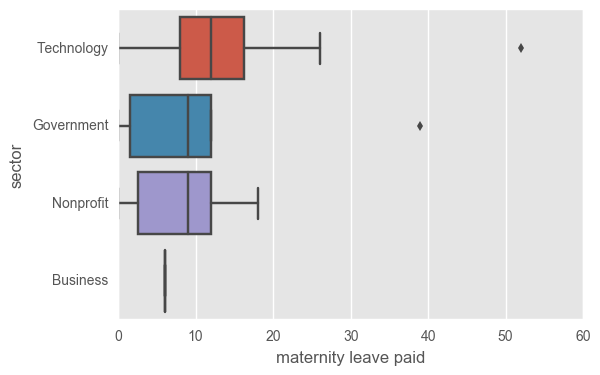

In [219]:
dists=sns.boxplot("maternity leave paid", "sector", data = sectordf)
plt.show(dists)

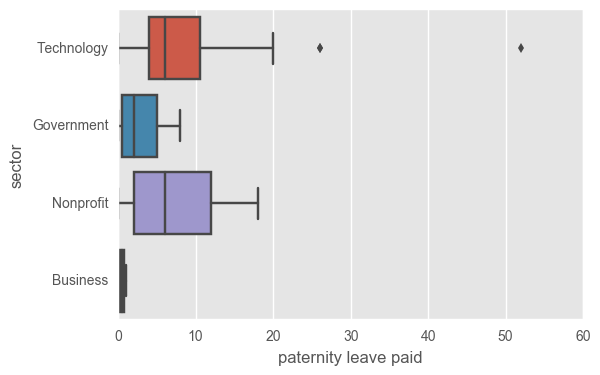

In [220]:
dists2 = sns.boxplot("paternity leave paid", "sector", data = sectordf)
plt.show(dists2)

Now that we've looked at an overview by industry, let's narrow this down and look at bar charts within each industry. We'll do 4 bar charts to look at the best and worst companies for paid parental leave.

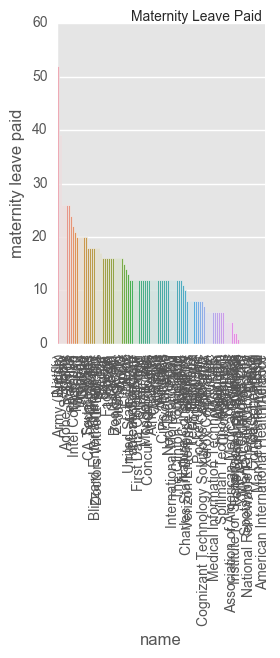

In [223]:
mat = sns.factorplot("name", "maternity leave paid", data = sectordf, kind = "bar") #data=veg to see vegetable bar plot
mat.set_xticklabels(rotation=90) #Rotate axis labels so they don't overlap
mat.fig.suptitle('Maternity Leave Paid')
plt.show(mat)

**Observations and Conclusions**

## Part 4: American Time Use Survey

**Social Context** 

The American Time Use Survey is a survey conducted by the Bureau of Labor Statistics (BLS). As specified in their [website](), "The American Time Use Survey (ATUS) measures the amount of time people spend doing various activities, such as paid work, childcare, volunteering, and socializing." For our project, we have information that men and women in America spend doing a variety of activities, including childcare and housework. We want to use the ATUS data to first visualize time spent by each gender on a specific activity (for both employed and unemployed males and females), and then test for any statistical differences. Ultimately, if these are significant, it could provide evidence to our hypothesis that there are systematic differences in our social fabric that explain the achievement gap. **(perception, corporate structures, household time)**

*More information on why the ATUS can give reliable and valid context to our explanation of the gender gap (ATUS sample size, methodology, etc. can be found on its [Wikipedia page](https://en.wikipedia.org/wiki/American_Time_Use_Survey).

**Methodology**

We downloaded data files from the ATUS website with the information we wanted, and displayed it in bar graphs. Then we conducted two-sample t tests to test for statistical signifiance. 

**Results**

The dataframe below displays the information that we will represent in our graph. 

In [185]:
def thepath(path = "~/Downloads/a6_1115.xlsx"):
    """
    Return a6_1115.xlsx based on the user's directory, with downloads as default.
    """
    path = os.path.expanduser(path)
    data = pd.read_excel(path, header = [1,2,3,4]).dropna() #drop na values
    return data

# CALL thepath() FOR YOUR DIRECTORY
data = thepath()
data.head()

Own household child under age 18                     Own household child under age 18  \
Activity                         Average hours per day spent in primary activities(1)   
                                                                      Married mothers   
                                                                   Employed full time   
Total, all activities                                                         24.00     
Personal care activities                                                       9.04     
Sleeping                                                                       8.21     
Household activities                                                           1.86     
Housework                                                                      0.74     

Own household child under age 18                                  \
Activity                                                           
                                                                   
                                 Employed part time Not employed   
Total, all activities                         24.00        24.00   
Personal care activities                       9.24         9.72   
Sleeping                                       8.48         9.02   
Household activities                           2.67         3.60   
Housework                                      1.15         1.55   

Own household child under age 18                                  \
Activity                                                           
                                 Married fathers(2)                
                                 Employed full time Not employed   
Total, all activities                         24.00        24.00   
Personal care activities                       8.71         9.64   
Sleeping                                       8.11         9.11   
Household activities                           1.18         2.22   
Housework                                      0.23         0.67   

Own household child under age 18                                               \
Activity                         Percent doing the activity on an average day   
                                                              Married mothers   
                                                           Employed full time   
Total, all activities                                                   100.0   
Personal care activities                                                100.0   
Sleeping                                                                 99.9   
Household activities                                                     87.6   
Housework                                                                48.2   

Own household child under age 18                                  \
Activity                                                           
                                                                   
                                 Employed part time Not employed   
Total, all activities                         100.0        100.0   
Personal care activities                      100.0        100.0   
Sleeping                                      100.0         99.9   
Household activities                           92.9         95.9   
Housework                                      63.9         72.1   

Own household child under age 18                                  
Activity                                                          
                                 Married fathers(2)               
                                 Employed full time Not employed  
Total, all activities                         100.0        100.0  
Personal care activities                      100.0         99.9  
Sleeping                                       99.9         99.4  
Household activities                           65.3         77.2  
Housework                                      17.4         39.2

In [186]:
# INFO FOR MARRIED MOTHERS
data_mothers = data["Own household child under age 18"]["Average hours per day spent in primary activities(1)"]["Married mothers"]
data_mothers.iloc[:,0]
data_mothers = data_mothers.ix[1:]

In [187]:
# INFO FOR MARRIED FATHERS
data_fathers = data["Own household child under age 18"]["Average hours per day spent in primary activities(1)"]["Married fathers(2)"]
data_fathers.iloc[:,0]
data_fathers = data_fathers.ix[1:]

The plot below displays differences in the time men and women spend doing specific activities.

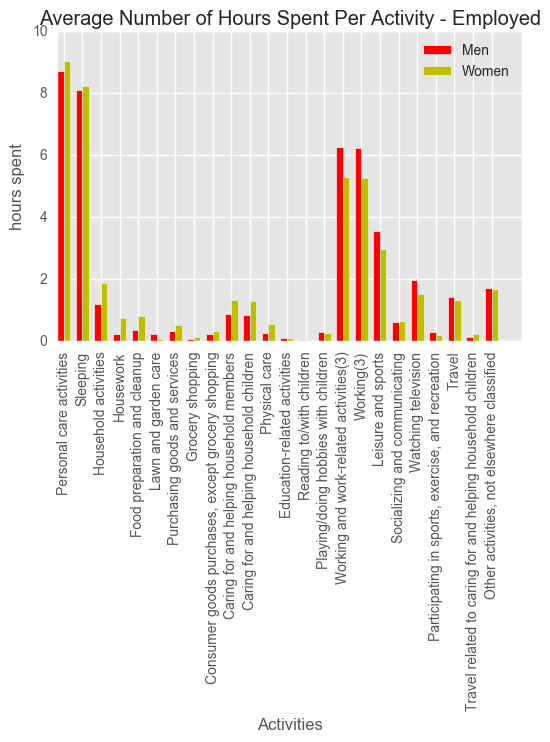

In [188]:
# GET INFO 
womenMeans = data_mothers['Employed full time'] #use the same stuff as wordcloud; only thing that changes is womenmeans, menmeans,
womenMeans = womenMeans.tolist()
womenMeans = tuple(womenMeans)

menMeans =data_fathers['Employed full time']
menMeans = menMeans.tolist()
menMeans = tuple(menMeans)

#print menMeans

# PLOTTING
N = 24

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, menMeans, width, color='r')

rects2 = ax.bar(ind+width, womenMeans, width, color='y')

# ADD SOME
ax.set_ylabel('hours spent')
ax.set_xlabel('Activities')
ax.set_title('Average Number of Hours Spent Per Activity - Employed')
ax.set_xticks(ind+width)
ax.set_xticklabels(data_fathers.index, rotation=90)
ax.legend( (rects1[0], rects2[0]), ('Men', 'Women') )

plt.show()

When we look at employed people (which is the sample we are more interested in), men on average spend more hours working and doing work related activities, and less time doing child care and household chores. From the graph above, you can also see other visible differences in purnchasing physical care, leisure and sports, and other categories which are interesting but less relevant to our study.

Next, we ask, is there a significant difference between the way that working men and women spend their days on average? This could potentially impact their wages and their work/childcare priorities. We run a two-sample t-test on differences in means with the following hypotheses: 

$ H_0: \mu_f = \mu_m$ , or independent samples have identical average (expected) values vs. $ H_A: \mu_f \neq \mu_m$, or our samples have different averages. 

We reject the null if our p-value from the test is less than our significance level, which we select to be $\alpha = 0.05$.

In [169]:
# IMPORT MORE DATA FROM BLS FOR STANDARD ERROR INFO 
def moreinfo(path = "~/Downloads/BLS_Data/"):
    """
    Return the appropriate dataframe based on data in the user's home directory.
    """
    df_list = []
    path = os.path.expanduser(path)
    files_xls = glob.glob(os.path.join(path, '*.xlsx'))
    for f in files_xls:
        #print f
        frame = pd.read_excel(f, header = 13)
        frame.drop(['Unnamed: 4', 'Unnamed: 5'], axis = 1, inplace = True)
        #print frame
        variable = os.path.splitext(os.path.basename(f))[0].split('-')[1]
        #print variable
        frame['Variable'] = variable
        df_list.append(frame)
        
    return pd.concat(df_list)

df = moreinfo()
df.head()

Year  Period  Estimate  Standard Error  \
0  2005  Annual      1.29           0.079   
1  2006  Annual      1.18           0.059   
2  2007  Annual      1.25           0.062   
3  2008  Annual      1.34           0.097   
4  2009  Annual      1.50           0.092   

                                            Variable  
0  Caring for and helping household children, Par...  
1  Caring for and helping household children, Par...  
2  Caring for and helping household children, Par...  
3  Caring for and helping household children, Par...  
4  Caring for and helping household children, Par...

We'll run some t-tests on the three categories of activities we're most interested in.

In [189]:
def ttests(variable):
    """
    Return the p-values for relevant activities.
    """
    #AVGS
    women_working = df[df['Variable'] == variable + ', Women']
    men_working = df[df['Variable'] == variable + ', Men']

    #SEs
    women_working_values = women_working['Estimate']
    men_working_values = men_working['Estimate']
    alpha = .05
    t_stat, p_val = stats.ttest_ind(women_working_values, men_working_values)
    return p_val

The p-values are below.

In [200]:
# HOURS SPENT WORKING
print "The p-value for differences in means between hours spent working for employed males and females is", ttests('Working, Employed')

# HOURS SPENT DOING HOUSEHOLD ACTIVITIES
print "The p-value for differences in means between hours spent on household activities for employed males and females is",ttests('Household activities (includes travel)')

# HOURS SPENT ON TAKING CARE OF CHILDREN
print "The p-value for differences in means between hours spent on childcare for employed males and females is",ttests('Caring for and helping household children, Parents of household children')

The p-value for differences in means between hours spent working for employed males and females is 2.61151842154e-15
The p-value for differences in means between hours spent on household activities for employed males and females is 1.43925129063e-20
The p-value for differences in means between hours spent on childcare for employed males and females is 2.91582782161e-16


**Observations and Comments**

In the bargraph that we made above from the American Time Use Survey, we can see that there are visible differences in the time that women and men doing many common activities, including working, household chores, childcare, gardening, sports, and more. Out of all the activities, we are most concerned with working, household chores, and childcare, so we conducted two-sample t-test for differences in means at a significance level of $\alpha = 0.05$. 

In all the above cases, our p-values were very small, and therefore we are able to reject the null hypothesis. We have evidence that there is a significant difference between the average number of hours spent on these activities for employed men and for employed women.

We believe these results are extremely important for a few reasons. First of all, the way Americans spend their time is reflective of success in the workplace: if married and working men spend more time working than married and working women, and less time doing housework and childcare, a gender achievement gap naturally follows. The magnitude of this difference (it is significant at any reasonable $\alpha$ suggests that the way men and women spend their time gives us a possible explanation for this gap. Second of all, these results lead to more questions: can we actually conclude that the achievement gap exists because men spend more time working and less time doing household activities than women? How can we determine the nature of that trade-off? Is this something that is rooted in other social structures, or is it a choice that each married couple (in the ATUS) consciously makes? 

Although we cannot answer many of these questions through simply looking at numbers and surveys, there is an undeniable and quantifiable achievement gap, as well as a quantifiable difference in time use across gender. Since major decisions and workforce potential is likely affected not just by workplace performance, but by the sum of each person's life and activities, the ATUS does a good job of depicting these subtleties and pointing at an association between time use and gender-related employment achievement. 

Ultimately, the three takeaways for working, household chores, and childcare tie into our previous sections and indicate that these are important factors that can explain explicit or implicit barriers to success that women face, not only in the workplace, but in the structure of their daily lives as well.

## Conclusion and Considerations 

